# Code for making predictions with and without news features

## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "/Users/abdalrhman/Documents/DC/data/" # Define data path

In [2]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

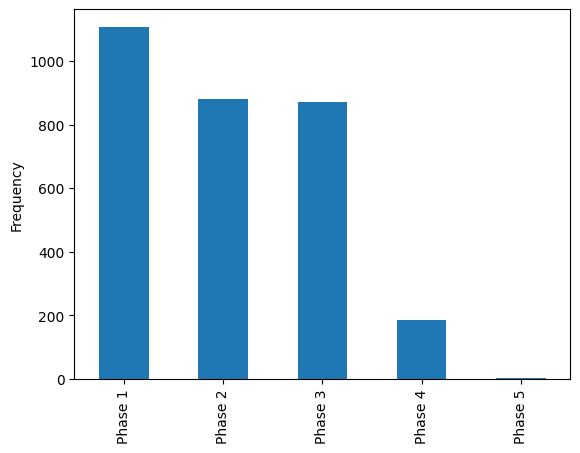

In [3]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

/var/folders/23/t6vxp3bn5l30631pqx4tkbfw0000gn/T/ipykernel_21668/480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


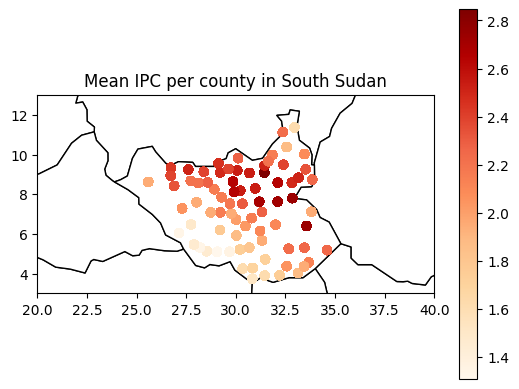

In [4]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [5]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [6]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [7]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [8]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 05 Sep 2023   Prob (F-statistic):          4.40e-196
Time:                        22:46:26   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

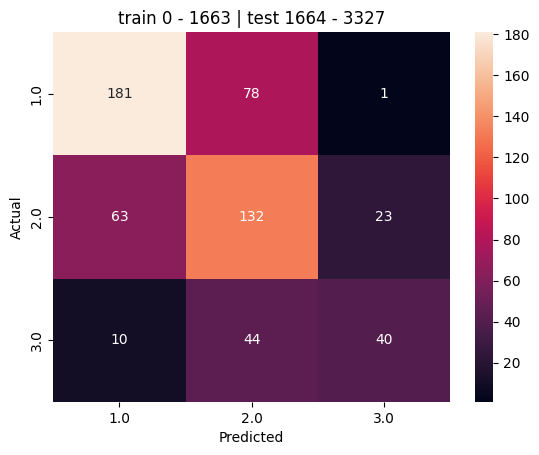

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     549.6
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:46:26   Log-Likelihood:                -1508.3
No. Observations:                2626   AIC:                             3031.
Df Residuals:                    2619   BIC:                             3072.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1836 

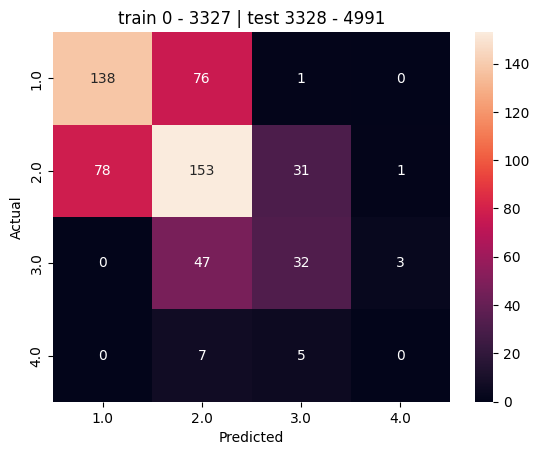

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     931.0
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:46:27   Log-Likelihood:                -2591.1
No. Observations:                4290   AIC:                             5196.
Df Residuals:                    4283   BIC:                             5241.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2779 

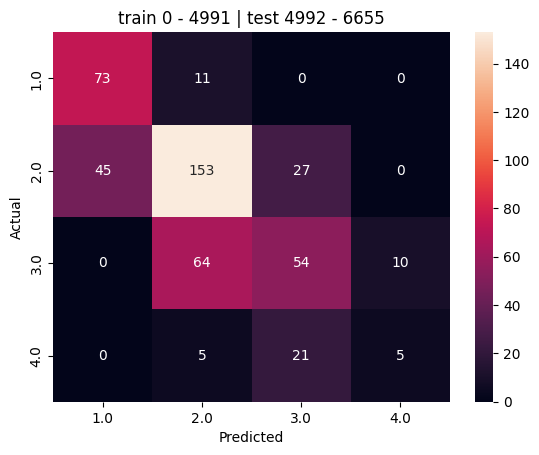

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1791.
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:46:27   Log-Likelihood:                -3594.1
No. Observations:                5954   AIC:                             7202.
Df Residuals:                    5947   BIC:                             7249.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2726 

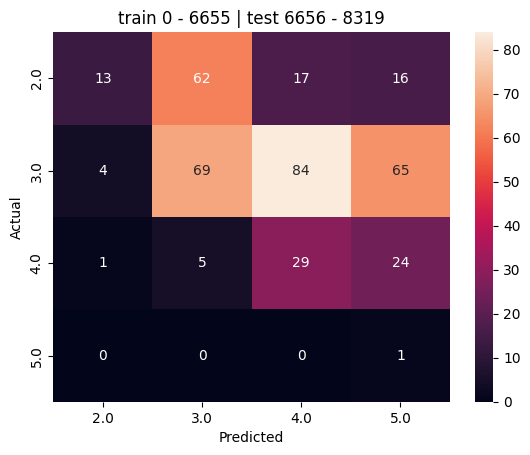

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2985.
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:46:27   Log-Likelihood:                -4798.7
No. Observations:                7618   AIC:                             9611.
Df Residuals:                    7611   BIC:                             9660.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2922 

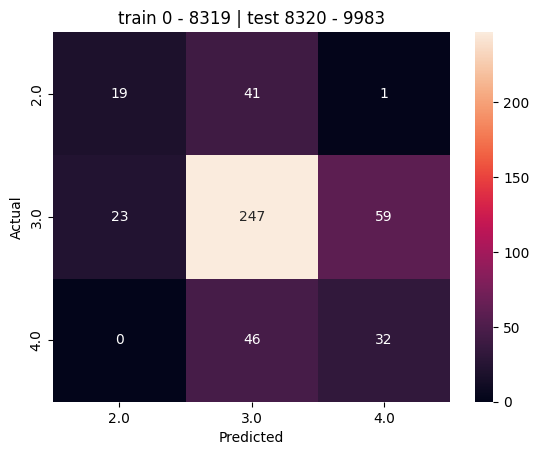

Mean MAE: 0.59
Mean R2: 0.62


<Figure size 640x480 with 0 Axes>

In [9]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [11]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [12]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

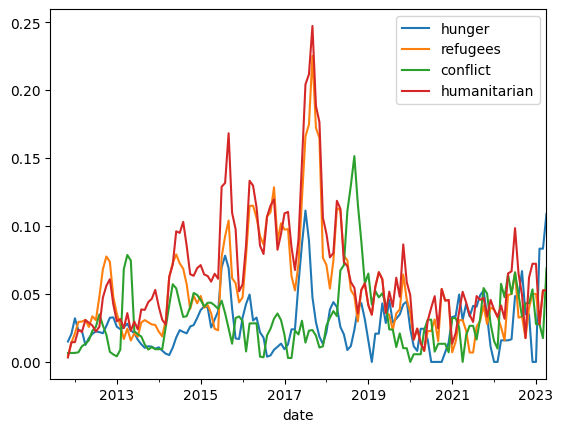

In [13]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

news_features.plot();

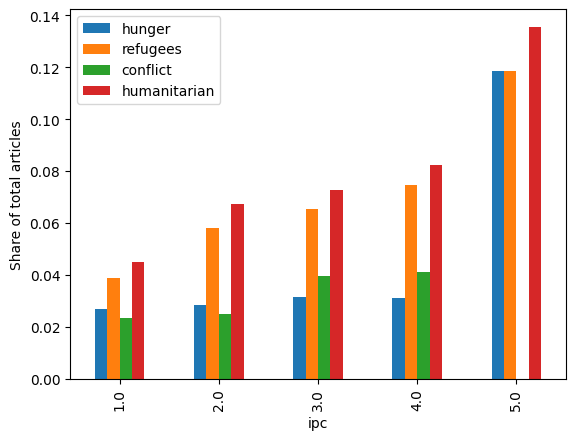

In [14]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

## Predicting using news features

In [15]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 05 Sep 2023   Prob (F-statistic):          4.40e-196
Time:                        22:54:40   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

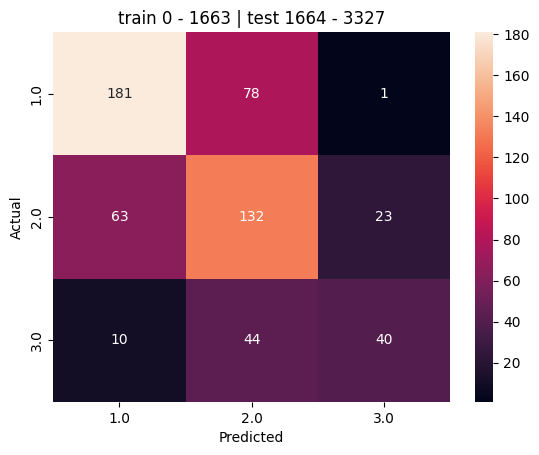

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     241.8
Date:                Tue, 05 Sep 2023   Prob (F-statistic):          7.96e-273
Time:                        22:54:41   Log-Likelihood:                -569.77
No. Observations:                1144   AIC:                             1162.
Df Residuals:                    1133   BIC:                             1217.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.8536 

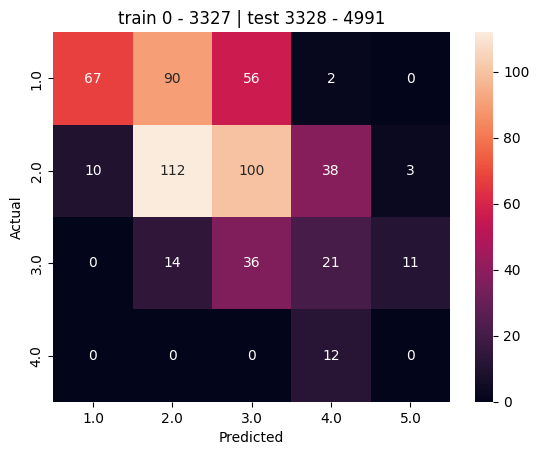

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     461.3
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:54:41   Log-Likelihood:                -1630.5
No. Observations:                2808   AIC:                             3283.
Df Residuals:                    2797   BIC:                             3348.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5755 

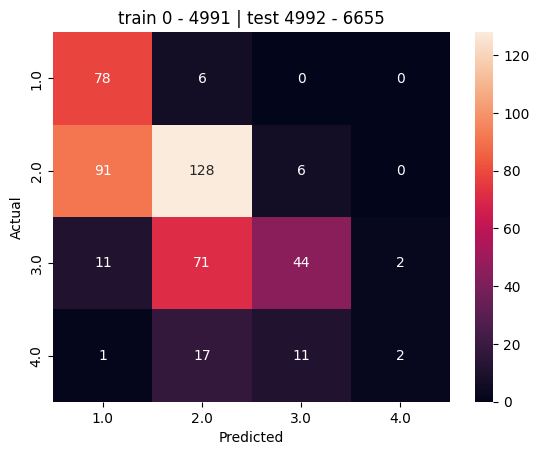

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     902.5
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:54:41   Log-Likelihood:                -2687.1
No. Observations:                4472   AIC:                             5396.
Df Residuals:                    4461   BIC:                             5467.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3685 

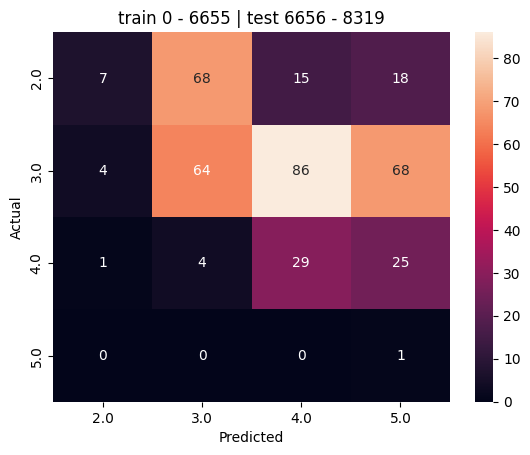

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1468.
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:54:42   Log-Likelihood:                -3893.2
No. Observations:                6136   AIC:                             7808.
Df Residuals:                    6125   BIC:                             7882.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2560 

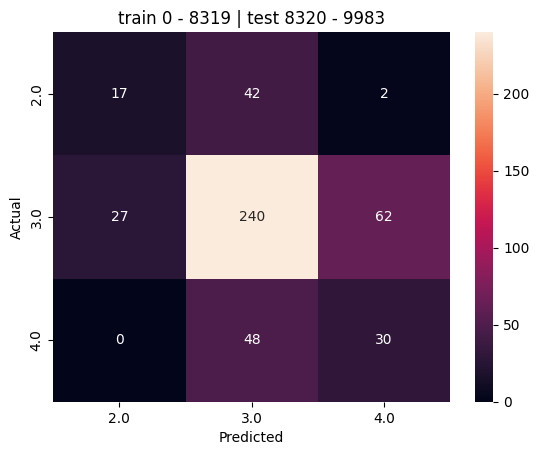

Mean MAE: 0.71
Mean R2: 0.66


<Figure size 640x480 with 0 Axes>

In [16]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [17]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  962
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 Sep 2023   Pseudo R-squ.:                  0.7213
Time:                        22:54:52   Log-Likelihood:                -23.041
converged:                       True   LL-Null:                       -82.676
Covariance Type:            nonrobust   LLR p-value:                 1.108e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9214      2.560     -6.610      0.000     -21.939     -11.904
ipc_lag_1      7.5452      1

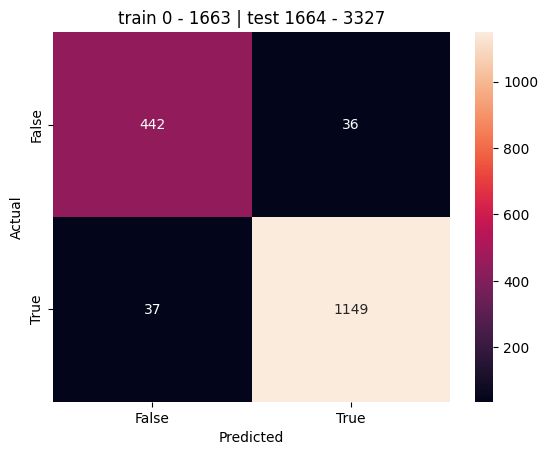

Optimization terminated successfully.
         Current function value: 0.196510
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 2626
Model:                          Logit   Df Residuals:                     2622
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 Sep 2023   Pseudo R-squ.:                  0.4129
Time:                        22:54:52   Log-Likelihood:                -516.04
converged:                       True   LL-Null:                       -878.95
Covariance Type:            nonrobust   LLR p-value:                5.241e-157
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0771      0.344    -23.471      0.000      -8.752      -7.403
ipc_lag_1      3.0044      0.

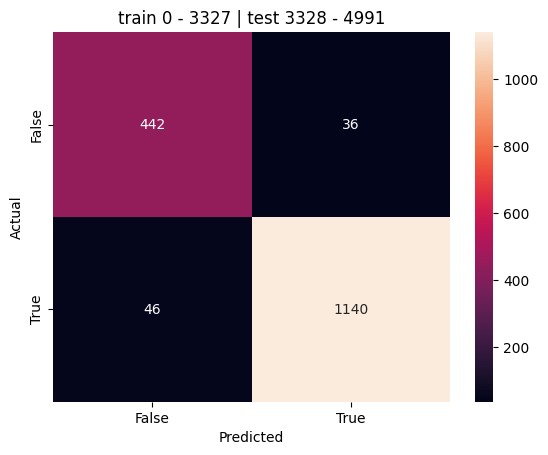

Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 4290
Model:                          Logit   Df Residuals:                     4286
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 Sep 2023   Pseudo R-squ.:                  0.3941
Time:                        22:54:53   Log-Likelihood:                -947.83
converged:                       True   LL-Null:                       -1564.4
Covariance Type:            nonrobust   LLR p-value:                4.853e-267
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8526      0.262    -29.949      0.000      -8.367      -7.339
ipc_lag_1      2.9520      0.

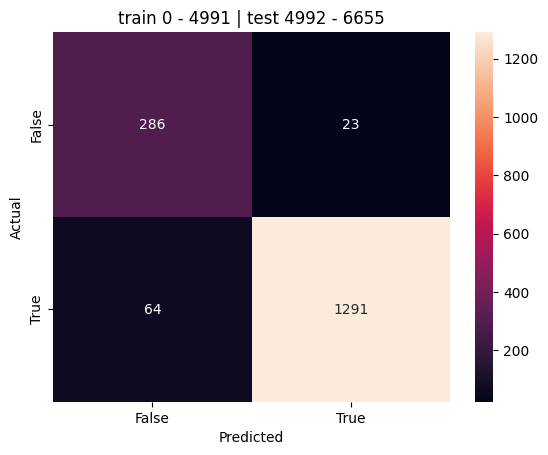

Optimization terminated successfully.
         Current function value: 0.263542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 5954
Model:                          Logit   Df Residuals:                     5950
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 Sep 2023   Pseudo R-squ.:                  0.4349
Time:                        22:54:53   Log-Likelihood:                -1569.1
converged:                       True   LL-Null:                       -2776.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8860      0.209    -37.780      0.000      -8.295      -7.477
ipc_lag_1      2.8618      0.

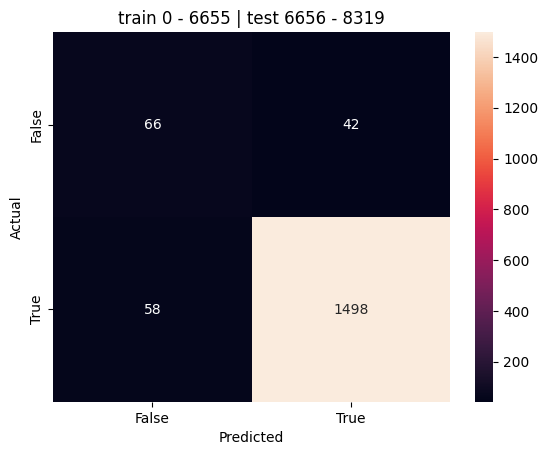

Optimization terminated successfully.
         Current function value: 0.297659
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 7618
Model:                          Logit   Df Residuals:                     7614
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 Sep 2023   Pseudo R-squ.:                  0.5120
Time:                        22:54:53   Log-Likelihood:                -2267.6
converged:                       True   LL-Null:                       -4646.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2706      0.182    -45.491      0.000      -8.627      -7.914
ipc_lag_1      2.6647      0.

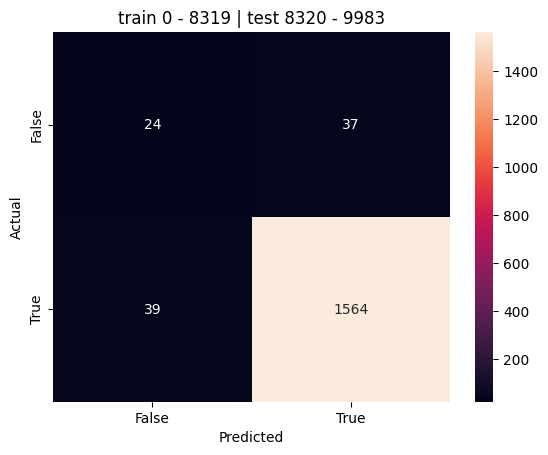

Mean Acc: 0.95


<Figure size 640x480 with 0 Axes>

In [18]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc